# Best Recommendation Algorithm

## Objective
The dataset includes test of different recommendation algorithms and the scroll list recommended by each algorithm on the lead articles. The objective was to find the best recommendation algorithm based on their recommendations of the articles on any lead article.

## Summary
Though algorithm C has recommended the articles most number of times in the provided dataset but users doesn't often click on the first article recommended by it. Hence, the weighted average scroll depth of algorithm C is less than that of A and B.
In this case, algorithm A perfoms better on an average than the other two recommendation algorithms.

In [2]:
# Import all the libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

### Data Exploration

Load the dataset and understand the variables present in it.

In [3]:
# Loading the dataset

scroll_test=pd.read_csv('scroll_test_views.csv')
scroll_test.head(5)

,lead_article_url,scroll_article_id,scroll,test_branch,timestamp
0,https://www.reuters.com/article/us-storm-harve...,USKCN1B80II,"[USKCN1B7083,USKCN1B8177,USKCN1B80II,USKCN1B80...",C,2017-08-28 13:00:06.754
1,https://www.reuters.com/article/us-usa-trump-m...,USKCN1B8177,"[USKCN1B806D,USKCN1B8177,USKCN1B7083,USKCN1B80...",C,2017-08-28 13:00:07.743
2,https://www.reuters.com/article/us-usa-navy-cr...,USKCN1B803W,"[USKCN1B803W,USKCN1B80II,USKCN1B80CA,USKCN1B81...",A,2017-08-28 13:00:11.541
3,https://www.reuters.com/article/us-storm-harve...,USKCN1B80SL,"[USKCN1B7083,USKCN1B812J,USKCN1B80SL,USKCN1B80...",A,2017-08-28 13:00:27.644
4,https://www.reuters.com/article/us-germany-ele...,USKCN1B70F2,"[USKCN1B70F2,USKCN1B80TR,USKCN1B803W,USKCN1B80...",B,2017-08-28 13:00:28.155


In [4]:
# Check the information and the null values in the dataset

scroll_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 204061 entries, 0 to 204060
Data columns (total 5 columns):
lead_article_url     204061 non-null object
scroll_article_id    204061 non-null object
scroll               204061 non-null object
test_branch          204061 non-null object
timestamp            204061 non-null object
dtypes: object(5)
memory usage: 7.8+ MB


As there are three recommendation algorithms recommending the articles. Checking the number of times A, B , C algorithms have made recommendations

In [4]:
scroll_test['test_branch'].value_counts()


C    85167
A    61030
B    57864
Name: test_branch, dtype: int64

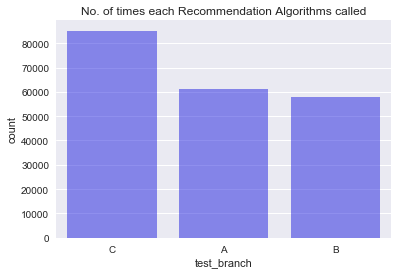

In [7]:
sns.countplot(x='test_branch', data=scroll_test, color='b', alpha=0.5).set(title='No. of times each Recommendation Algorithms called')

As seen from the plot above the number of recommendations given by algorithms A,B,C are not equal. The data could be biased if we will consider it like this only.
Hence we should take the weighted average at the end, which would give a weight to the scroll depth and the  number of recommendations by an algorithm

### Data Cleaning

It was observed that the ordered list in the scroll column is of string type and needs to be converted to a list type.
Hence, created a new column 'scroll_new' which includes the list of articles in list format.

In [8]:
scroll_test['scroll_new']=scroll_test['scroll'].apply(lambda x:x.strip('['))
scroll_test['scroll_new']=scroll_test['scroll_new'].apply(lambda x:x.strip(']'))
scroll_test['scroll_new']=scroll_test['scroll_new'].apply(lambda x:x.split(","))

In [9]:
scroll_test.head(2)

,lead_article_url,scroll_article_id,scroll,test_branch,timestamp,scroll_new
0,https://www.reuters.com/article/us-storm-harve...,USKCN1B80II,"[USKCN1B7083,USKCN1B8177,USKCN1B80II,USKCN1B80...",C,2017-08-28 13:00:06.754,"[USKCN1B7083, USKCN1B8177, USKCN1B80II, USKCN1..."
1,https://www.reuters.com/article/us-usa-trump-m...,USKCN1B8177,"[USKCN1B806D,USKCN1B8177,USKCN1B7083,USKCN1B80...",C,2017-08-28 13:00:07.743,"[USKCN1B806D, USKCN1B8177, USKCN1B7083, USKCN1..."


### Feature Engineering

Inorder to get the scroll depth of each recommendation algorithm, created a new column 'scroll_depth' based on the position of the scroll_article_id in the scroll list. The general assumption is that after reading the lead article, the user next clicks on the article given in scroll_article_id.
Thus, 'scroll_depth' gives the position of the scroll_article_id in scroll list.

In [10]:
# Get the index of the scroll-article_id in scroll list.

def trial(row):
    li=row['scroll_new']
    el=row['scroll_article_id']
    position=-1
    try:
        position=li.index(el)
        
    except ValueError:
        position=-1
    return position

In [11]:
scroll_test['scroll_depth']=scroll_test[['scroll_new','scroll_article_id']].apply(trial, axis=1)
scroll_test.head(2)

,lead_article_url,scroll_article_id,scroll,test_branch,timestamp,scroll_new,scroll_depth
0,https://www.reuters.com/article/us-storm-harve...,USKCN1B80II,"[USKCN1B7083,USKCN1B8177,USKCN1B80II,USKCN1B80...",C,2017-08-28 13:00:06.754,"[USKCN1B7083, USKCN1B8177, USKCN1B80II, USKCN1...",2
1,https://www.reuters.com/article/us-usa-trump-m...,USKCN1B8177,"[USKCN1B806D,USKCN1B8177,USKCN1B7083,USKCN1B80...",C,2017-08-28 13:00:07.743,"[USKCN1B806D, USKCN1B8177, USKCN1B7083, USKCN1...",1


In [12]:
scroll_depth_counts = scroll_test.groupby(['test_branch','scroll_depth'])['scroll_depth'].count().reset_index(name="depth_count")
scroll_depth_counts_df=pd.DataFrame(scroll_depth_counts)
scroll_depth_counts_df['sd_dc']=scroll_depth_counts['scroll_depth']*scroll_depth_counts['depth_count']

### Weighted Average of recommendations
Taking the weighted average of the scroll depths of the three recommendation algorithms.

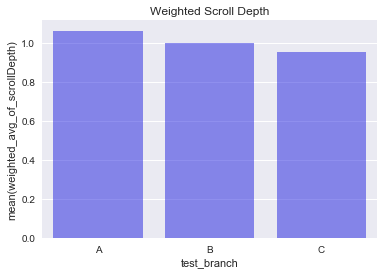

In [13]:
scroll_depth_avg=scroll_depth_counts_df.groupby('test_branch')['sd_dc'].sum()/scroll_depth_counts_df.groupby('test_branch')['depth_count'].sum()
scroll_depth_avg_df=pd.DataFrame(scroll_depth_avg).reset_index()
scroll_depth_avg_df.rename(columns={0:'weighted_avg_of_scrollDepth'}, inplace=True)
sns.barplot(x='test_branch', y='weighted_avg_of_scrollDepth', data=scroll_depth_avg_df, color='b', alpha=0.5).set(title='Weighted Scroll Depth')

### Observation

Though algorithm C has recommended the articles most number of times in the provided dataset but users doesn't often click on the first article recommended by it. Hence, the weighted average scroll depth of algorithm C is less than that of A and B.
In this case, algorithm A perfoms better on an average than the other two recommendation algorithms.